## THE ORIGINAL THINGS (LEFT THEM IN FOR REFERENCE)

In [44]:
import numpy as np
import h5py

fn = "image1-competition.hdf5"

with h5py.File(fn, "r") as f:
    data = np.array(f["data"])
    wns = np.array(f["wns"])
    tissue_mask = np.array(f["tissue_mask"])
    classes = np.array(f["classes"])

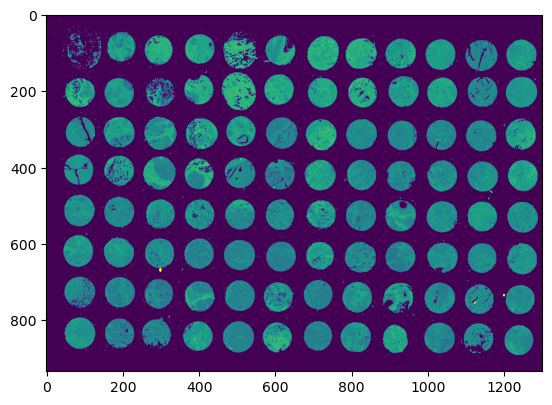

In [45]:
# display the whole image
import matplotlib.pyplot as plt

def nearest_ind(a, v):
    return np.abs(a - v).argmin()

im = data[:, :, nearest_ind(wns, 1560)]
plot = plt.imshow(im, vmin=0, vmax=1)

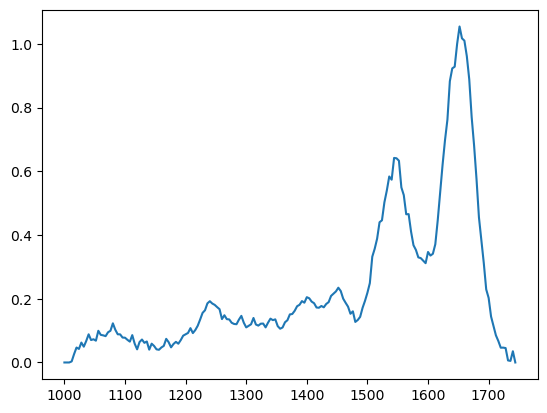

In [46]:
# a single "pixel" is a spectrum
plt.plot(wns, data[110, 220])
plt.show()

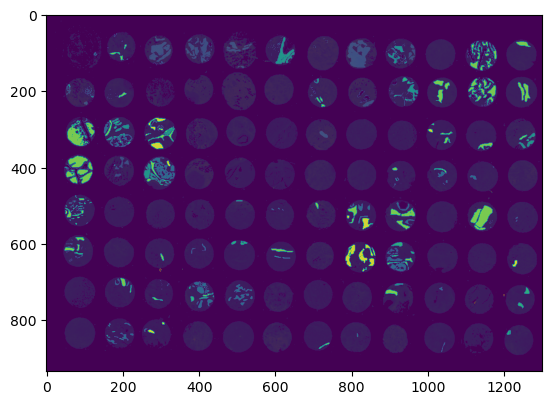

In [47]:
# the classes
plt.imshow(data[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)
plt.imshow(classes[:, :], alpha=0.8)

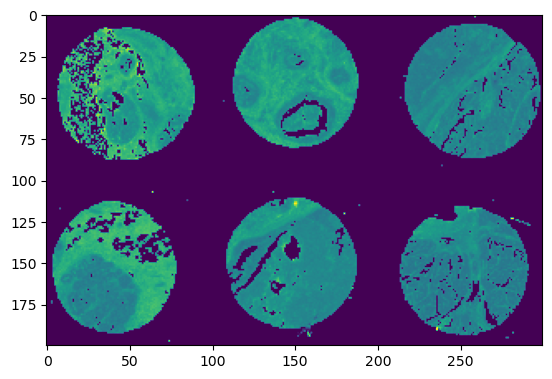

In [48]:
data_predict = data[265:465,360:660]
plt.imshow(data_predict[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

In [49]:
annotated_sel = classes != -1
X = data[annotated_sel]
y = classes[annotated_sel]

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

lr = LogisticRegression(max_iter=10000, C=0.001)
lr.fit(X, y)

LogisticRegression(C=0.001, max_iter=10000)

## GETTING SPLITS FOR CROSS VALIDATION

[37464  1598    74   189] 1861
here
[36158  2109    53  1005] 3167
here
[36317  2409   106   484     9] 3008
here
[38064   234  1027] 1261
here
[38863   157   107   101    97] 462
[39015    94     2   214] 310
[37299   897   243   519   159   208] 2026
here
[35715   301  3309] 3610
here
[34473     3   869   516   126  2575   763] 4852
here
[39137    60   128] 188
[39004   271     4    46] 321
[38210    28   362    21   629    75] 1115
here
[34280   379  1199   666     7  2719    75] 5045
here
[39046   267     6     2     4] 279
[39213    15    97] 112
[38945   283    97] 380
[38639    41   488   157] 686
[39242    35    48] 83
[36880   592  1403   450] 2445
here
[37325    42  1958] 2000
here
[38488   188   649] 837
[38686   166   174   299] 639
[36483   859    17   234   276  1456] 2842
here
[39204   121] 121
[38922   140   228    35] 403
[37611  1405    86   117   106] 1714
here
[38967    80   278] 358
[39034    43   248] 291
[37582   309    37    97] 443
[38025] 0
[37916    25    84]

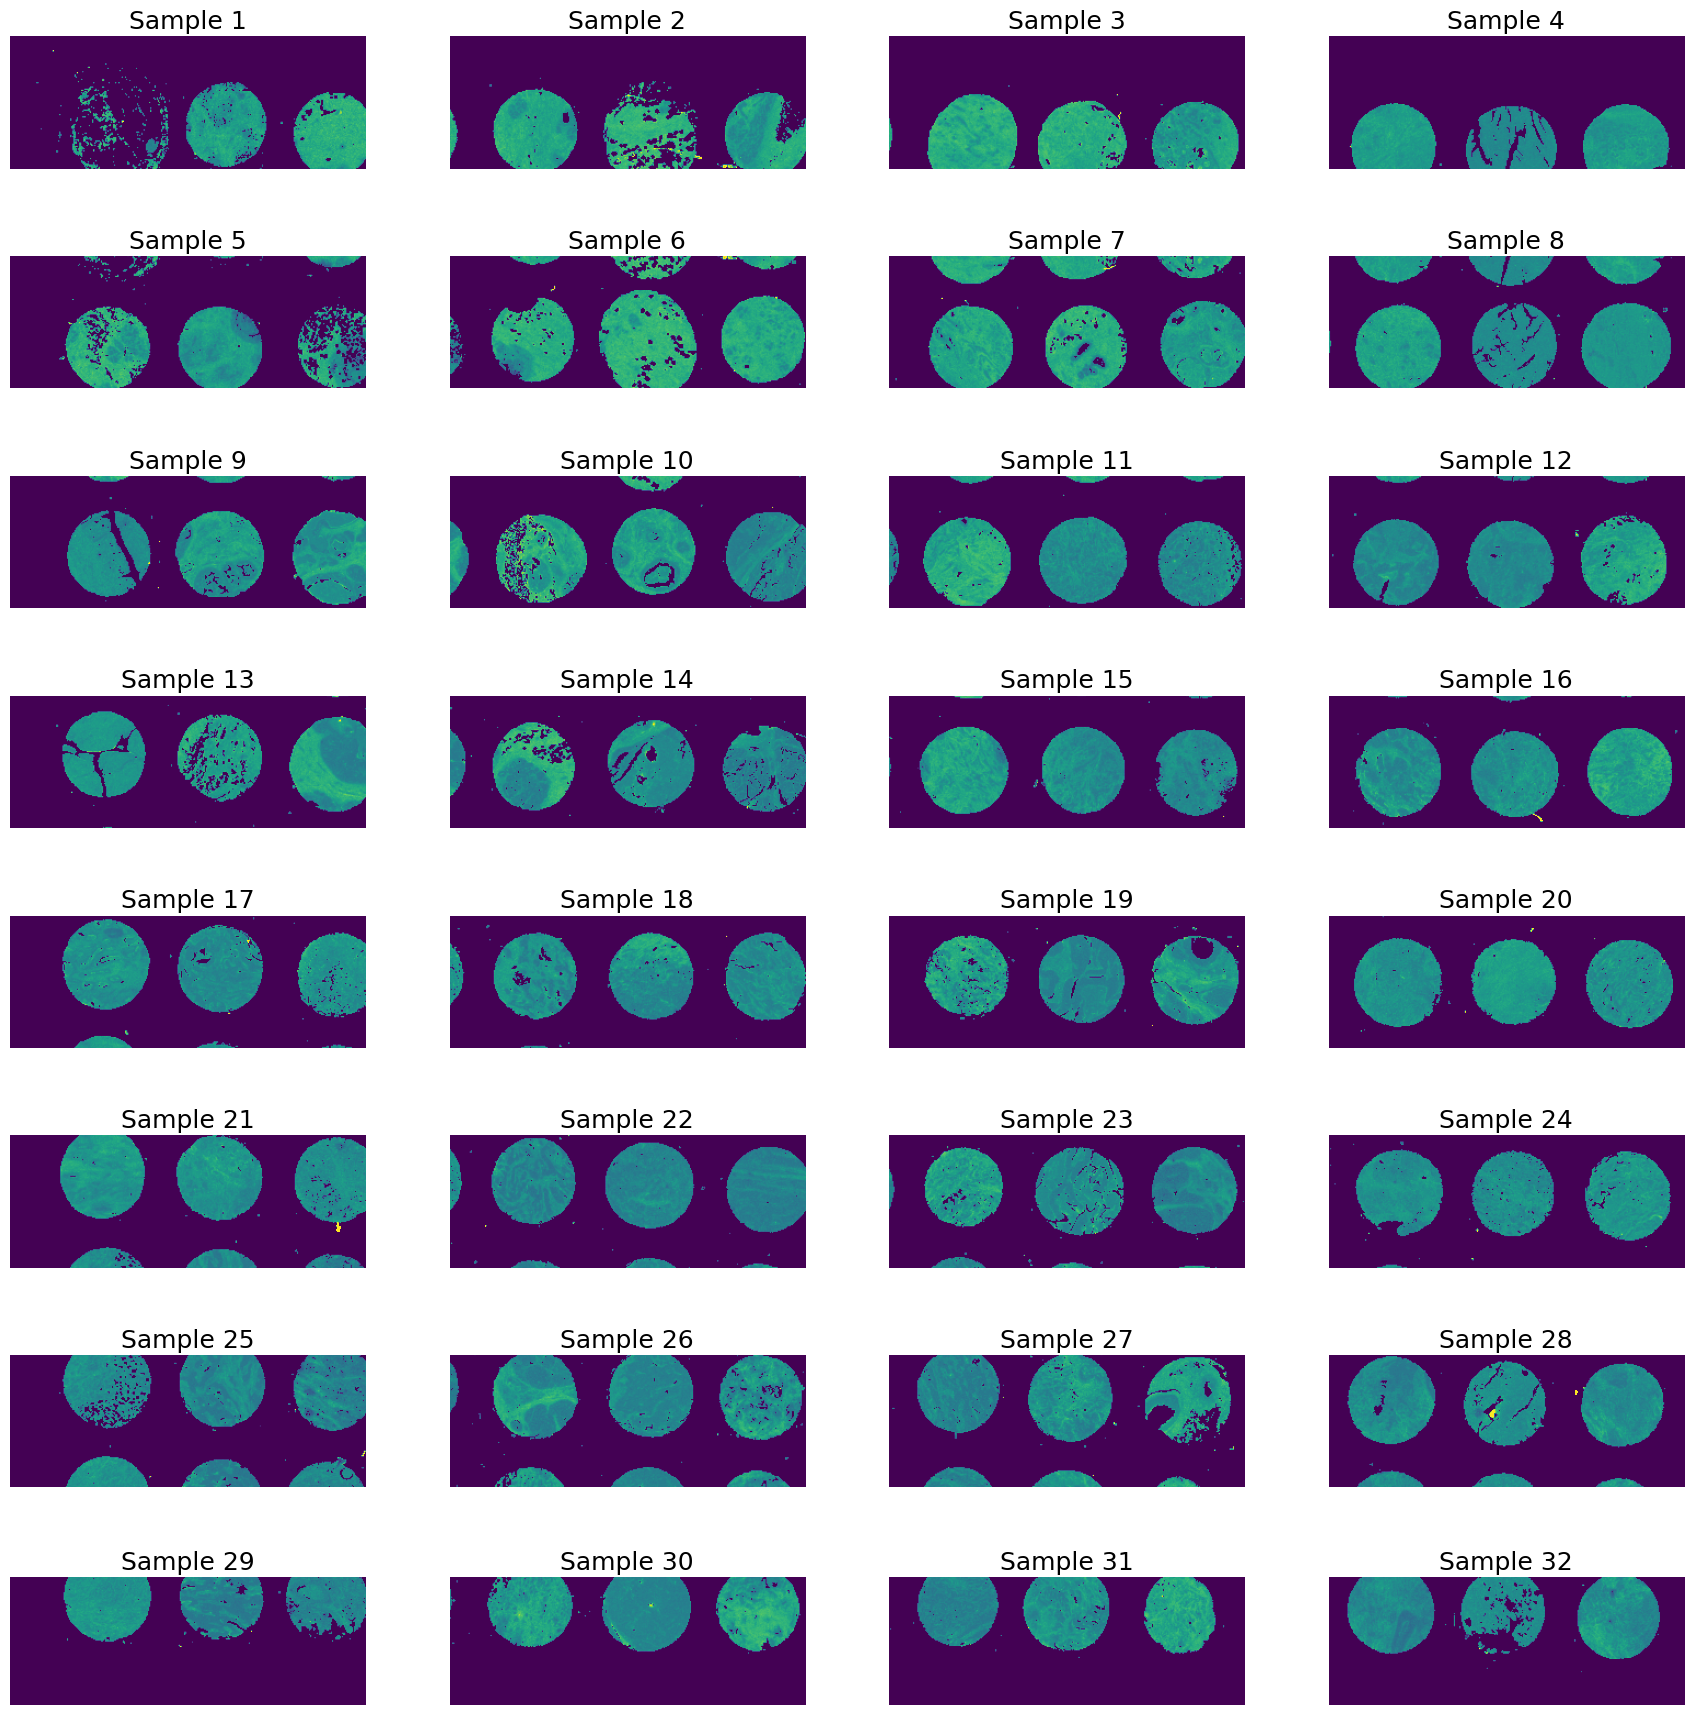

In [60]:
# Only one validation set
data_val = data[475:700,770:980]
#plt.imshow(data_val[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)


# CROSS VALIDATION SPLITS

splits = []
n_row_splits = 8
n_col_splits = 4

row_size = 934 // n_row_splits 
col_size = 1300 // n_col_splits  


fig, axes = plt.subplots(n_row_splits, n_col_splits, figsize=(18, 18))  
fig.tight_layout(pad=3)

for i in range(n_row_splits):
    for j in range(n_col_splits):
        row_start = i * row_size + 5
        if i == n_row_splits - 1:
            row_end = 934
        else:
            row_end = (i + 1) * row_size + 10

        col_start = j * col_size
        if j == n_col_splits - 1:
            col_end = 1300
        else:
            col_end = (j + 1) * col_size


        square = data[row_start:row_end, col_start:col_end]


        print(np.unique(classes[row_start:row_end, col_start:col_end], return_counts=True)[1], np.sum(np.unique(classes[row_start:row_end, col_start:col_end], return_counts=True)[1][1:]))

        # append only if there is enough annotated data
        if np.sum(np.unique(classes[row_start:row_end, col_start:col_end], return_counts=True)[1][1:]) > 1000:
            print("here")
            annotated_sel_val = np.zeros_like(annotated_sel, dtype=bool)
            annotated_sel_val[row_start:row_end, col_start:col_end] = 1
            splits.append(annotated_sel_val)



        ax = axes[i, j]
        ax.imshow(square[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)
        ax.set_title(f"Sample {i*n_col_splits+j + 1}", fontsize=18)
        ax.axis('off')

plt.savefig("report/figures/samples.png")

## MODELS

In [38]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, input_features = 187 ,num_classes = 3):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv1d(input_features, input_features, 15),
            nn.ReLU(),
            nn.BatchNorm1d(input_features),
            nn.Conv1d(input_features, input_features, 5),
            nn.ReLU(),
            nn.BatchNorm1d(input_features),
            nn.Conv1d(input_features, input_features, 3),
            nn.ReLU(),
            nn.BatchNorm1d(input_features),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Linear(83, num_classes)


    def forward(self, x):
        x = self.conv_layer1(x)
        x = x.view(x.size(0), -1) 
        print(x.shape)
        return self.fc(x)

In [39]:
import torch.nn as nn

n1 = 75
n2 = 15
n3 = 15

class MLP(nn.Module):
    def __init__(self, input_features=187, num_classes=3,n1=n1, n2 = n2, n3 = n3):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_features,n1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(n1,n2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(n2,num_classes),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            # nn.Linear(n3, num_classes)
        )

    def forward(self, x):
        return self.net(x)


## CROSS VALIDATION

In [ ]:
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np


epochs = 500
# Define the hyperparameters grid
lr_list = [0.001]  # [0.001, 0.0005, 0.0002, 0.0001]
n1_list =  range(15,151, 10)
n2_list =  range(5, 51, 10)
epochs_list = [100,200,300,400,500]



device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Loop over all hyperparameter combinations
for epochs in epochs_list:
    for lr in lr_list:
        #print(f"Testing learning rate = {lr}")
        for n1 in n1_list:
            #print(f"Testing n1 = {n1}")
            for n2 in n2_list:
                #print(f"Testing n2 = {n2}")
                np.random.seed(2)
                torch.manual_seed(2)
                
                # Loop over each split
                losses = []
                for i, annotated_sel_val in enumerate(splits):
                    #print(f"Split {i}")
                    
                    # Create the train and validation masks
                    annotated_train_mask = annotated_sel & ~annotated_sel_val
                    annotated_val_mask = annotated_sel & annotated_sel_val

                    # Split data
                    X_train = data[annotated_train_mask]
                    y_train = classes[annotated_train_mask]
                    X_val = data[annotated_val_mask]
                    y_val = classes[annotated_val_mask]

                    # Add row, column indices to features
                    val_rows, val_cols = np.where(annotated_val_mask)
                    X_val = np.array([np.concatenate([np.array([train_row, train_col]), x]) for x, train_row, train_col in zip(X_val, val_rows, val_cols)])

                    train_rows, train_cols = np.where(annotated_train_mask)
                    X_train = np.array([np.concatenate([np.array([train_row, train_col]), x]) for x, train_row, train_col in zip(X_train, train_rows, train_cols)])

                    # Scale features
                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    X_val = scaler.transform(X_val)


                    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
                    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
                    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
                    y_val = torch.tensor(y_val, dtype=torch.long).to(device)

                    # Model, loss, optimizer
                    model = MLP(X_train.shape[1], len(np.unique(y_train.cpu().numpy())), n1=n1, n2=n2).to(device)
                    loss_fn = nn.CrossEntropyLoss()
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

                    # Training loop
                    for epoch in range(epochs):
                        model.train()
                        optimizer.zero_grad()

                        outputs = model(X_train)
                        loss = loss_fn(outputs, y_train)
                        loss.backward()
                        optimizer.step()

                        train_loss = loss.item()

                        # Validation loop
                        model.eval()
                        with torch.inference_mode():
                            val_outputs = model(X_val)
                            val_loss = loss_fn(val_outputs, y_val).item()
                            predictions = torch.argmax(val_outputs, dim=1)
                            val_acc = (predictions == y_val).sum().item() / y_val.size(0)

                    losses.append(val_loss)
                
                avg_loss = np.mean(losses)
                print(f"Average loss: {avg_loss}, for n1 = {n1}, n2 = {n2}, epochs = {epochs}")
                        

Using device: cuda
Average loss: 1.241465504352863, for n1 = 15, n2 = 5, epochs = 100
Average loss: 0.9899614820113549, for n1 = 15, n2 = 15, epochs = 100
Average loss: 0.8938781573222234, for n1 = 15, n2 = 25, epochs = 100
Average loss: 0.8660285518719599, for n1 = 15, n2 = 35, epochs = 100
Average loss: 0.8483352133860955, for n1 = 15, n2 = 45, epochs = 100
Average loss: 1.1335514256587396, for n1 = 25, n2 = 5, epochs = 100
Average loss: 0.9243479095972501, for n1 = 25, n2 = 15, epochs = 100
Average loss: 0.7840260083858783, for n1 = 25, n2 = 25, epochs = 100
Average loss: 0.777595593379094, for n1 = 25, n2 = 35, epochs = 100
Average loss: 0.7171061153595264, for n1 = 25, n2 = 45, epochs = 100
Average loss: 1.0431536527780385, for n1 = 35, n2 = 5, epochs = 100
Average loss: 0.8394597103962531, for n1 = 35, n2 = 15, epochs = 100
Average loss: 0.7633782006227053, for n1 = 35, n2 = 25, epochs = 100
Average loss: 0.669988350226329, for n1 = 35, n2 = 35, epochs = 100
Average loss: 0.65643

## TUNING WITH ONLY ONE VALIDATION SPLIT

In [ ]:
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from tqdm import tqdm

# THIS ONE WAS USED FOR TESTING WITH ONLY ONE VALIDATION SPLIT

validation = False
# Create masks
annotated_sel_val = np.zeros_like(annotated_sel, dtype=bool)
annotated_sel_val[475:700,770:980] = 1

if validation:
    annotated_train_mask = annotated_sel & ~annotated_sel_val
    annotated_val_mask   = annotated_sel &  annotated_sel_val
else:
    annotated_train_mask = annotated_sel
    annotated_val_mask   = None  # Not used

# Split data
X_train = data[annotated_train_mask]
y_train = classes[annotated_train_mask]

if validation:
    X_val = data[annotated_val_mask]
    y_val = classes[annotated_val_mask]
    val_rows, val_cols = np.where(annotated_val_mask)
    X_val = np.array([np.concatenate([np.array([train_row, train_col]), x]) for x, train_row, train_col in zip(X_val, val_rows, val_cols)])
    # Get (row, column) indices of training points
train_rows, train_cols = np.where(annotated_train_mask)

# Now add the position to the features

X_train = np.array([np.concatenate([np.array([train_row, train_col]), x]) for x, train_row, train_col in zip(X_train, train_rows, train_cols)])


# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
if validation:
    X_val = scaler.transform(X_val)

# Convert to tensors and move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
#X_train = X_train.unsqueeze(1) # For CNNS
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
if validation:
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    #X_val = X_val.unsqueeze(1)# For CNNS
    y_val = torch.tensor(y_val, dtype=torch.long).to(device)


min_val_loss = 0.45

for lr in [0.001, 0.0005, 0.0002, 0.0001]:
    print(f"lr ={lr}")
    for n1 in range(15,151, 10):
        print(f"n1 = {n1}")
        for n2 in range(5, 51, 10):
            print(f"n2 = {n2}")
            np.random.seed(2)
            torch.manual_seed(2)

            # Model, loss, optimizer
            model = MLP(X_train.shape[1], len(np.unique(y_train.cpu().numpy())), n1=n1, n2=n2).to(device)
            #model = CNN(X_train.shape[1], len(np.unique(y_train.cpu().numpy()))).to(device)

            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0) # for mlp lr = 0.0001

            # Training loop
            epochs = 15000

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                outputs = model(X_train)
                loss = loss_fn(outputs, y_train)
                loss.backward()
                optimizer.step()

                train_loss = loss.item()

                # Validation
                if validation:
                    model.eval()
                    with torch.inference_mode():
                        val_outputs = model(X_val)
                        val_loss = loss_fn(val_outputs, y_val).item()
                        predictions = torch.argmax(val_outputs, dim=1)
                        val_acc = (predictions == y_val).sum().item() / y_val.size(0)
                    if val_loss < min_val_loss:
                        min_val_loss = val_loss
                        print(val_loss, epoch, n1, n2, lr)
                    #print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}, Val loss={val_loss:.4f}, Val acc={val_acc:.4f}")
                else:
                    print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}")

## CHECKING THE RESULTS WITH OBTAINED HYPERPARAMS

In [ ]:
import torch
n1 = 45
n2 = 45
epochs = 300
lr = 0.001
lam = 0

validation =False # Set to False to train on all annotated data without validation
# Create masks
annotated_sel_val = np.zeros_like(annotated_sel, dtype=bool)
annotated_sel_val[475:700,770:980] = 1

if validation:
    annotated_train_mask = annotated_sel & ~annotated_sel_val
    annotated_val_mask   = annotated_sel &  annotated_sel_val
else:
    annotated_train_mask = annotated_sel
    annotated_val_mask   = None  # Not used

# Split data
X_train = data[annotated_train_mask]
y_train = classes[annotated_train_mask]

if validation:
    X_val = data[annotated_val_mask]
    y_val = classes[annotated_val_mask]
    val_rows, val_cols = np.where(annotated_val_mask)
    X_val = np.array([np.concatenate([np.array([train_row, train_col]), x]) for x, train_row, train_col in zip(X_val, val_rows, val_cols)])
# Get (row, column) indices of training points
train_rows, train_cols = np.where(annotated_train_mask)

# Now add the position to the features
X_train = np.array([np.concatenate([np.array([train_row, train_col]), x]) for x, train_row, train_col in zip(X_train, train_rows, train_cols)])


# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
if validation:
    X_val = scaler.transform(X_val)

# Convert to tensors and move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
#X_train = X_train.unsqueeze(1) # For CNNS
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
if validation:
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device) 
    #X_val = X_val.unsqueeze(1)# For CNNS
    y_val = torch.tensor(y_val, dtype=torch.long).to(device)

np.random.seed(2)
torch.manual_seed(2)

# Model, loss, optimizer
model = MLP(X_train.shape[1], len(np.unique(y_train.cpu().numpy())), n1=n1, n2=n2).to(device)
#model = CNN(X_train.shape[1], len(np.unique(y_train.cpu().numpy()))).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lam) # for mlp lr = 0.0001

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss = loss.item()

    # Validation
    if validation:
        model.eval()
        with torch.inference_mode():
            val_outputs = model(X_val)
            val_loss = loss_fn(val_outputs, y_val).item()
            predictions = torch.argmax(val_outputs, dim=1)
            val_acc = (predictions == y_val).sum().item() / y_val.size(0)

        print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}, Val loss={val_loss:.4f}, Val acc={val_acc:.4f}")
    else:
        print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}")

Using device: cuda
Epoch 1/300: Train loss=1.8329
Epoch 2/300: Train loss=1.7975
Epoch 3/300: Train loss=1.7664
Epoch 4/300: Train loss=1.7405
Epoch 5/300: Train loss=1.7160
Epoch 6/300: Train loss=1.6925
Epoch 7/300: Train loss=1.6671
Epoch 8/300: Train loss=1.6427
Epoch 9/300: Train loss=1.6165
Epoch 10/300: Train loss=1.5889
Epoch 11/300: Train loss=1.5635
Epoch 12/300: Train loss=1.5382
Epoch 13/300: Train loss=1.5118
Epoch 14/300: Train loss=1.4848
Epoch 15/300: Train loss=1.4591
Epoch 16/300: Train loss=1.4319
Epoch 17/300: Train loss=1.4087
Epoch 18/300: Train loss=1.3839
Epoch 19/300: Train loss=1.3569
Epoch 20/300: Train loss=1.3286
Epoch 21/300: Train loss=1.3114
Epoch 22/300: Train loss=1.2864
Epoch 23/300: Train loss=1.2613
Epoch 24/300: Train loss=1.2420
Epoch 25/300: Train loss=1.2178
Epoch 26/300: Train loss=1.1955
Epoch 27/300: Train loss=1.1742
Epoch 28/300: Train loss=1.1550
Epoch 29/300: Train loss=1.1399
Epoch 30/300: Train loss=1.1196
Epoch 31/300: Train loss=1.106

## ALSO TRIED BATCHES (IT DIDN'T WORK BETTER)

In [ ]:
# Option with batches, for larger models

from torch.utils.data import DataLoader, TensorDataset

np.random.seed(42)
torch.manual_seed(42)

validation = True # Set to False to train on all annotated data without validation
batch_size = 1000

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

if validation:
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Define model
model = MLP(X_train.shape[1], len(np.unique(y_train.cpu().numpy()))).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
epochs = 150

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    if validation:
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.inference_mode():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                predictions = torch.argmax(outputs, dim=1)
                correct += (predictions == y_batch).sum().item()
                total += y_batch.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total

        print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}, Val loss={val_loss:.4f}, Val acc={val_acc:.4f}")
    else:
        print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}")


## PREDICTIONS

In [65]:
data_predict = data[265:465,360:660]

# take spectra for prediction in a linearized sequence
lin_data_predict = data_predict.reshape(-1, data_predict.shape[-1])

# Create row and column indices
rows = np.arange(265, 465) 
cols = np.arange(360, 660)  

# Build full grid of (row, col) positions
grid_rows, grid_cols = np.meshgrid(rows, cols, indexing='ij')
grid_rows = grid_rows.flatten()
grid_cols = grid_cols.flatten()

# Add positions to the spectra
lin_data_predict = np.array([
    np.concatenate([np.array([r, c]), spectrum]) 
    for spectrum, r, c in zip(lin_data_predict, grid_rows, grid_cols)
])

lin_data_predict = scaler.transform(lin_data_predict)

tissue_mask_predict = tissue_mask[265:465,360:660]

lin_data_predict_tensor = torch.tensor(lin_data_predict, dtype=torch.float32).to(device) 

# Predict
model.eval()
with torch.inference_mode():
    pred_logits = model(lin_data_predict_tensor)
    pred_probs = torch.softmax(pred_logits, dim=1) 
    pred_labels = torch.argmax(pred_probs, dim=1)


# Reshape the predicted probabilities to match the data dimensions
pred_probs_reshaped = pred_probs.cpu().numpy().reshape(data_predict.shape[:2] + lin_pred.shape[-1:])
pred_labels_reshaped = pred_labels.cpu().numpy().reshape(data_predict.shape[:2])

background_pred = np.array([0, 1, 0, 0, 0, 0], dtype=pred_probs_reshaped.dtype)

mask_region = ~tissue_mask_predict.astype(bool)
pred_probs_reshaped[mask_region] = background_pred

# Save the probabilities
np.save("basic_prediction_probs.npy", pred_probs_reshaped.astype(np.float32))
